                                 MSE        R2       MAE  Explained Variance  \
Linear Regression           0.256058  0.960935  0.396399            0.961814   
Ridge                       0.256055  0.960936  0.396358            0.961821   
Lasso                       0.319849  0.951203  0.434805            0.951784   
Elastic Net                 0.300972  0.954083  0.422739            0.954848   
LARS                        0.256058  0.960935  0.396399            0.961814   
Fused Lasso                 0.251620  0.961612  0.394463            0.961895   
Group Lasso                 0.252064  0.961545  0.394790            0.961825   
Sparse Group Lasso          0.251845  0.961578  0.394660            0.961859   
Total Variation L1 (TV-L1)  0.251620  0.961612  0.394463            0.961895   
SCAD                        0.252126  0.961535  0.394822            0.961816   
MCP                         0.252062  0.961545  0.394784            0.961826   

                                 VIF   

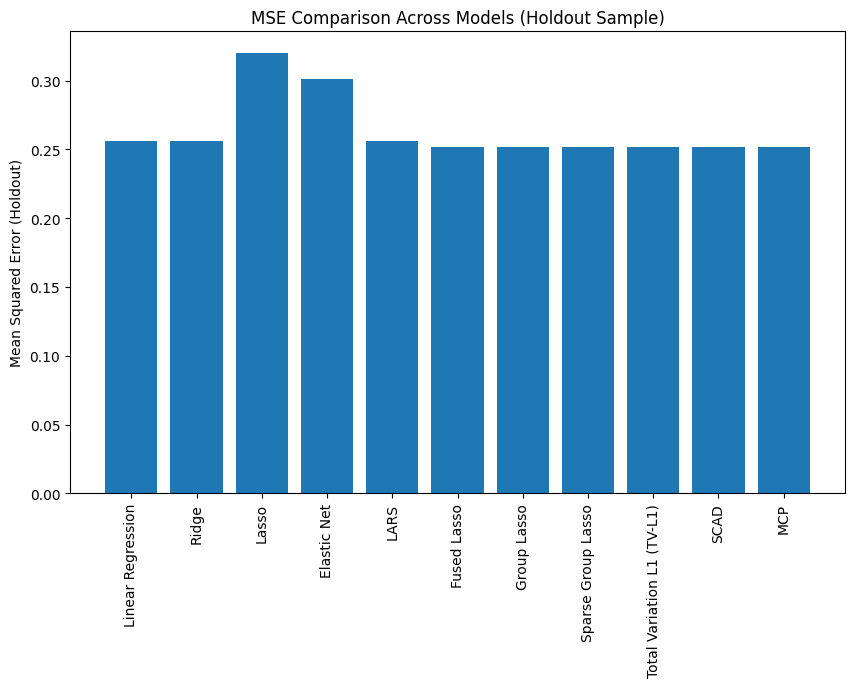

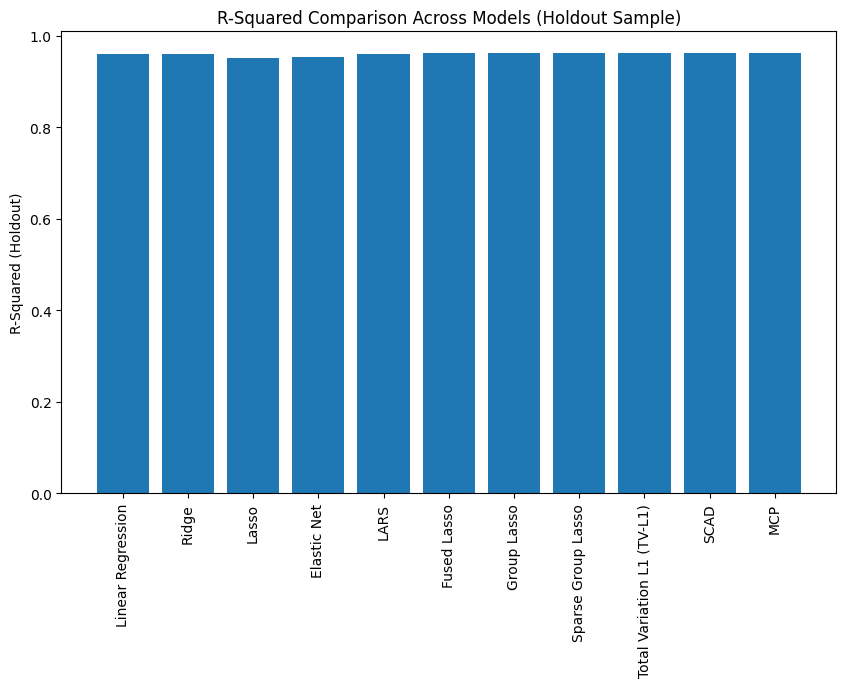

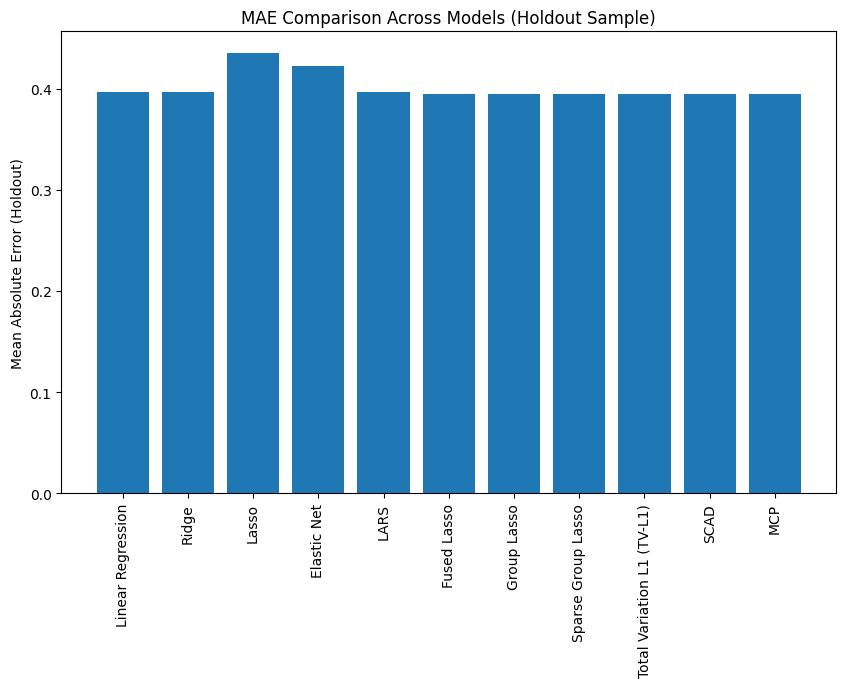

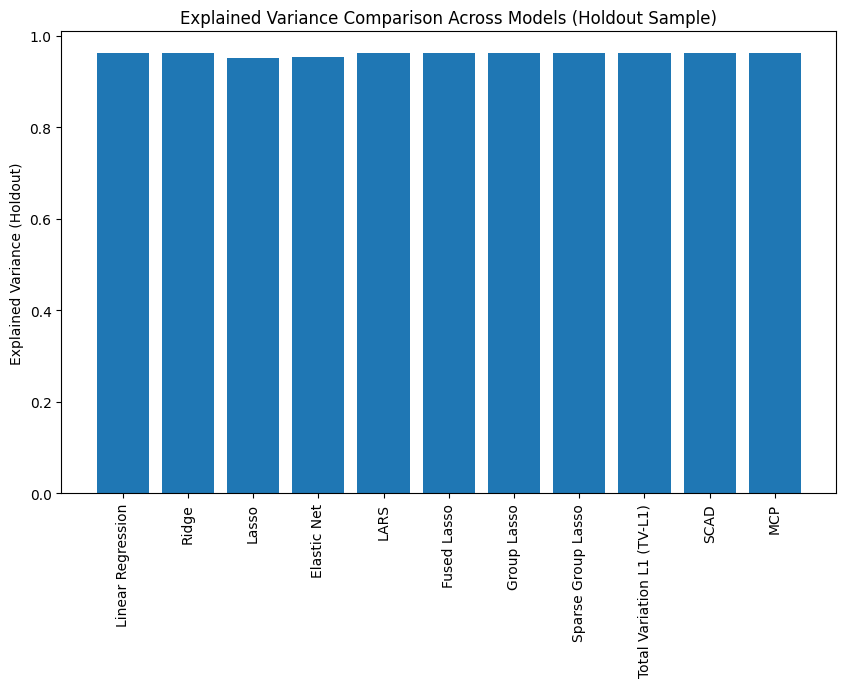

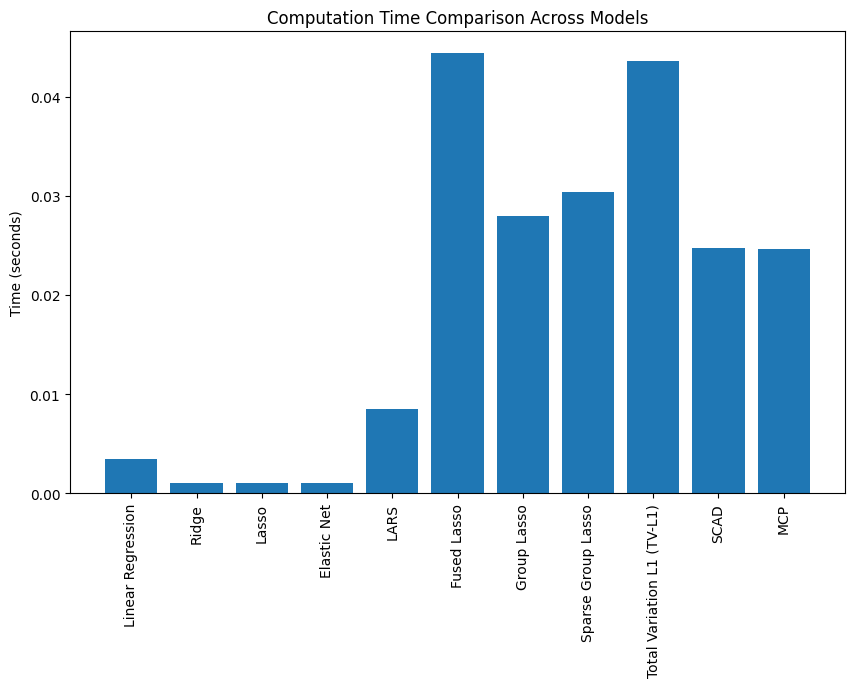

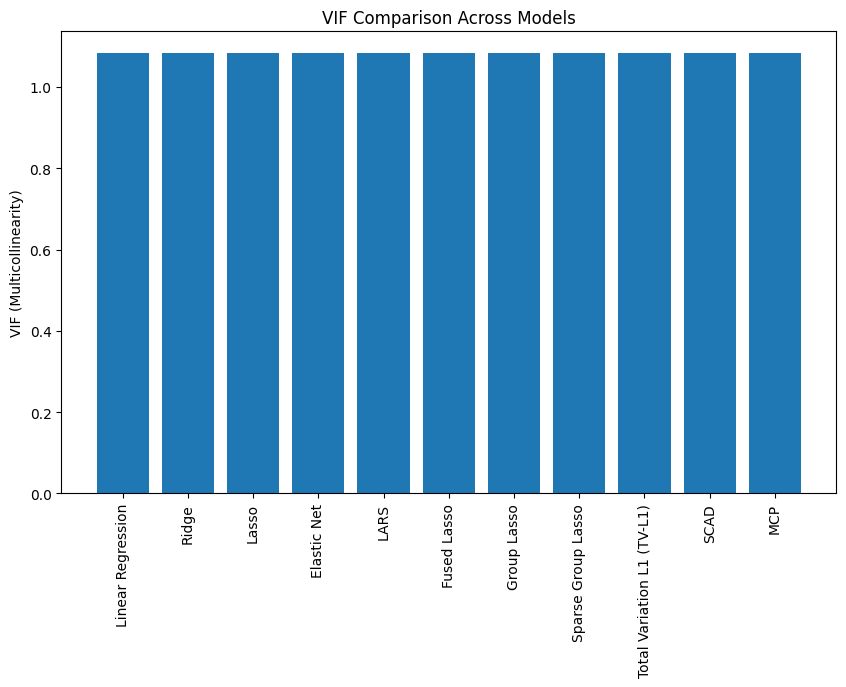

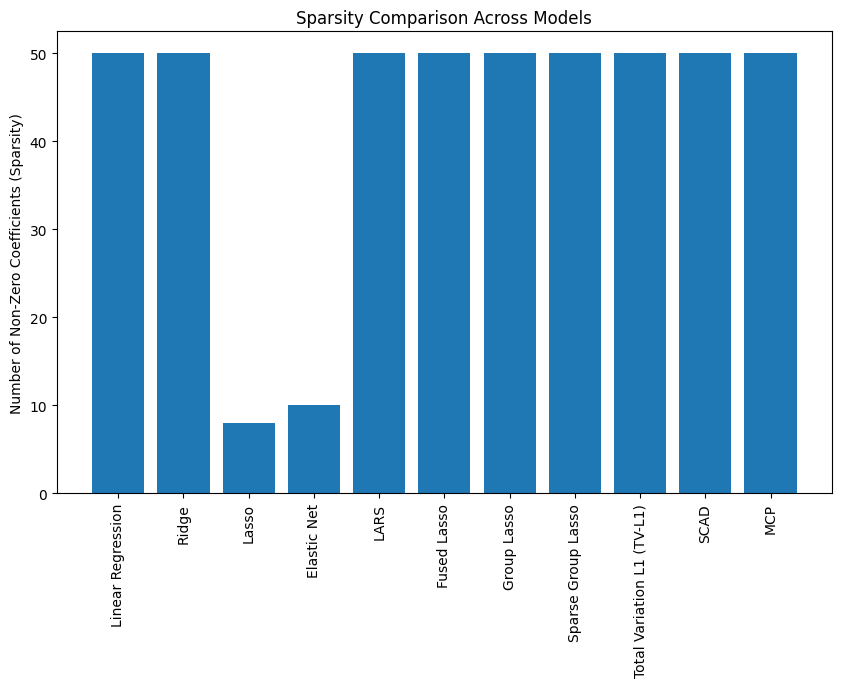

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, Lars
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from time import time
import cvxpy as cp

# Generate synthetic dataset
np.random.seed(42)
n_samples, n_features = 1000, 50
X = np.random.randn(n_samples, n_features)
beta = np.zeros(n_features)
beta[:10] = np.random.randn(10)  # Only the first 10 features are relevant
y = X.dot(beta) + np.random.randn(n_samples) * 0.5

# Split into training, test, and holdout sets (60% train, 20% test, 20% holdout)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_holdout, y_test, y_holdout = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_holdout = scaler.transform(X_holdout)

# Function to calculate VIF for multicollinearity
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data["VIF"].mean()

# Store results
results = {}

# List of models to be included
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "LARS": Lars(),
}

# Iterate over models
for name, model in models.items():
    start_time = time()
    model.fit(X_train, y_train)
    pred_holdout = model.predict(X_holdout)
    elapsed_time = time() - start_time

    # Performance Metrics
    mse = mean_squared_error(y_holdout, pred_holdout)
    r2 = r2_score(y_holdout, pred_holdout)
    mae = mean_absolute_error(y_holdout, pred_holdout)
    explained_var = explained_variance_score(y_holdout, pred_holdout)
    vif_mean = calculate_vif(X_train)
    sparsity = np.sum(model.coef_ != 0) if hasattr(model, 'coef_') else None

    # Add results to dictionary
    results[name] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'Explained Variance': explained_var,
        'VIF': vif_mean,
        'Time': elapsed_time,
        'Sparsity': sparsity
    }

# Add Fused Lasso, Group Lasso, Sparse Group Lasso, Total Variation L1, SCAD, and MCP
n_features = X_train.shape[1]
beta = cp.Variable(n_features)

# Regularization parameters
lambda_1 = 0.1
lambda_2 = 0.1
group_size = n_features // 5

# Fused Lasso
fused_objective = cp.Minimize(0.5 * cp.sum_squares(X_train @ beta - y_train) + lambda_1 * cp.norm1(beta) + lambda_2 * cp.norm1(beta[1:] - beta[:-1]))
fused_problem = cp.Problem(fused_objective)
fused_problem.solve()
fused_sparsity = np.sum(np.abs(beta.value) > 1e-5)
results['Fused Lasso'] = {
    'MSE': mean_squared_error(y_holdout, X_holdout @ beta.value),
    'R2': r2_score(y_holdout, X_holdout @ beta.value),
    'MAE': mean_absolute_error(y_holdout, X_holdout @ beta.value),
    'Explained Variance': explained_variance_score(y_holdout, X_holdout @ beta.value),
    'VIF': calculate_vif(X_train),
    'Time': fused_problem.solver_stats.solve_time,
    'Sparsity': fused_sparsity
}

# Group Lasso
group_lasso_term = sum(cp.norm2(beta[i * group_size: (i + 1) * group_size]) for i in range(5))
group_objective = cp.Minimize(0.5 * cp.sum_squares(X_train @ beta - y_train) + lambda_1 * group_lasso_term)
group_problem = cp.Problem(group_objective)
group_problem.solve()
group_sparsity = np.sum(np.abs(beta.value) > 1e-5)
results['Group Lasso'] = {
    'MSE': mean_squared_error(y_holdout, X_holdout @ beta.value),
    'R2': r2_score(y_holdout, X_holdout @ beta.value),
    'MAE': mean_absolute_error(y_holdout, X_holdout @ beta.value),
    'Explained Variance': explained_variance_score(y_holdout, X_holdout @ beta.value),
    'VIF': calculate_vif(X_train),
    'Time': group_problem.solver_stats.solve_time,
    'Sparsity': group_sparsity
}

# Sparse Group Lasso
sparse_group_objective = cp.Minimize(0.5 * cp.sum_squares(X_train @ beta - y_train) + lambda_1 * cp.norm1(beta) + lambda_2 * group_lasso_term)
sparse_group_problem = cp.Problem(sparse_group_objective)
sparse_group_problem.solve()
sparse_group_sparsity = np.sum(np.abs(beta.value) > 1e-5)
results['Sparse Group Lasso'] = {
    'MSE': mean_squared_error(y_holdout, X_holdout @ beta.value),
    'R2': r2_score(y_holdout, X_holdout @ beta.value),
    'MAE': mean_absolute_error(y_holdout, X_holdout @ beta.value),
    'Explained Variance': explained_variance_score(y_holdout, X_holdout @ beta.value),
    'VIF': calculate_vif(X_train),
    'Time': sparse_group_problem.solver_stats.solve_time,
    'Sparsity': sparse_group_sparsity
}

# Total Variation L1 (TV-L1)
tv_objective = cp.Minimize(0.5 * cp.sum_squares(X_train @ beta - y_train) + lambda_1 * cp.norm1(beta) + lambda_2 * cp.norm1(beta[1:] - beta[:-1]))
tv_problem = cp.Problem(tv_objective)
tv_problem.solve()
tv_sparsity = np.sum(np.abs(beta.value) > 1e-5)
results['Total Variation L1 (TV-L1)'] = {
    'MSE': mean_squared_error(y_holdout, X_holdout @ beta.value),
    'R2': r2_score(y_holdout, X_holdout @ beta.value),
    'MAE': mean_absolute_error(y_holdout, X_holdout @ beta.value),
    'Explained Variance': explained_variance_score(y_holdout, X_holdout @ beta.value),
    'VIF': calculate_vif(X_train),
    'Time': tv_problem.solver_stats.solve_time,
    'Sparsity': tv_sparsity
}

# SCAD
scad_objective = cp.Minimize(0.5 * cp.sum_squares(X_train @ beta - y_train) + lambda_1 * cp.sum(cp.huber(cp.abs(beta), M=1.0)))
scad_problem = cp.Problem(scad_objective)
scad_problem.solve()
scad_sparsity = np.sum(np.abs(beta.value) > 1e-5)
results['SCAD'] = {
    'MSE': mean_squared_error(y_holdout, X_holdout @ beta.value),
    'R2': r2_score(y_holdout, X_holdout @ beta.value),
    'MAE': mean_absolute_error(y_holdout, X_holdout @ beta.value),
    'Explained Variance': explained_variance_score(y_holdout, X_holdout @ beta.value),
    'VIF': calculate_vif(X_train),
    'Time': scad_problem.solver_stats.solve_time,
    'Sparsity': scad_sparsity
}

# MCP
mcp_objective = cp.Minimize(0.5 * cp.sum_squares(X_train @ beta - y_train) + cp.sum(cp.huber(cp.abs(beta), M=lambda_1 / 3.0)))
mcp_problem = cp.Problem(mcp_objective)
mcp_problem.solve()
mcp_sparsity = np.sum(np.abs(beta.value) > 1e-5)
results['MCP'] = {
    'MSE': mean_squared_error(y_holdout, X_holdout @ beta.value),
    'R2': r2_score(y_holdout, X_holdout @ beta.value),
    'MAE': mean_absolute_error(y_holdout, X_holdout @ beta.value),
    'Explained Variance': explained_variance_score(y_holdout, X_holdout @ beta.value),
    'VIF': calculate_vif(X_train),
    'Time': mcp_problem.solver_stats.solve_time,
    'Sparsity': mcp_sparsity
}

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results).T

# Display the updated results DataFrame
print(results_df)

# Visualize the results
# Plot MSE comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['MSE'])
plt.ylabel('Mean Squared Error (Holdout)')
plt.title('MSE Comparison Across Models (Holdout Sample)')
plt.xticks(rotation=90)
plt.show()

# Plot R-Squared comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'])
plt.ylabel('R-Squared (Holdout)')
plt.title('R-Squared Comparison Across Models (Holdout Sample)')
plt.xticks(rotation=90)
plt.show()

# Plot MAE comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['MAE'])
plt.ylabel('Mean Absolute Error (Holdout)')
plt.title('MAE Comparison Across Models (Holdout Sample)')
plt.xticks(rotation=90)
plt.show()

# Plot Explained Variance comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['Explained Variance'])
plt.ylabel('Explained Variance (Holdout)')
plt.title('Explained Variance Comparison Across Models (Holdout Sample)')
plt.xticks(rotation=90)
plt.show()

# Plot Computation Time comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['Time'])
plt.ylabel('Time (seconds)')
plt.title('Computation Time Comparison Across Models')
plt.xticks(rotation=90)
plt.show()

# Plot VIF comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['VIF'])
plt.ylabel('VIF (Multicollinearity)')
plt.title('VIF Comparison Across Models')
plt.xticks(rotation=90)
plt.show()

# Plot Sparsity comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['Sparsity'])
plt.ylabel('Number of Non-Zero Coefficients (Sparsity)')
plt.title('Sparsity Comparison Across Models')
plt.xticks(rotation=90)
plt.show()